In [1]:
# Compute the JJA MMM taking one single member for each model. Then compute the MMbias for each model.
# First for the mrsos and then for tas and z500.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import cftime
from scipy.interpolate import griddata
import matplotlib as mpl
import pandas as pd

In [2]:
path2era5 = '/bdd/ERA5/NETCDF/GLOBAL_025/1xmonthly/AN_SF/' # Soil Moisture is not already downloaded, but here the t2m, sstk and msl monthly fields are available.
path2cmip6 = '/bdd/CMIP6/CMIP/'

In [3]:
# Read a single ERA5 file to get the coordinates.
ds_era5 = xr.open_dataset(path2era5+'2020/t2m.2020.asme5.GLOBAL_025.nc')
lon = ds_era5.longitude.values
lat = ds_era5.latitude.values

extent = [360-110, 360-90, 30, 50] # minlon, maxlon, minlat, maxlat.
# Area of interet in CONUS, defined in Teng et al. (2019)

In [4]:
# Define the season of interest.
label_season = 'JJA'

In [16]:
# When reading the folders which have mrsos data, save the paths, so that the same exact models are used for atmospheric
# variables.

first_field = 1
counter = 0
used_path2members = []
used_members = []
used_models = []

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            # Select the first member.
            member = list_of_members[0]
            
            if os.path.exists(path2members + member + '/Lmon/mrsos/gr/latest/'):
                path2files = path2members + member + '/Lmon/mrsos/gr/latest/'
            elif os.path.exists(path2members + member + '/Lmon/mrsos/gr1/latest/'):
                path2files = path2members + member + '/Lmon/mrsos/gr1/latest/'
            elif os.path.exists(path2members + member + '/Lmon/mrsos/gn/latest/'):
                path2files = path2members + member + '/Lmon/mrsos/gn/latest/'
            else:
                path2files = ''
                    
            if path2files: # If some data are available the path2file is not empty.               
                # Open and concatenate all the files whose final date is after 197901.
                list_of_files = sorted(os.listdir(path2files))
                if list_of_files: # Check whether there are output files to be read.
                    first_file = 1
                    for ll in range(len(list_of_files)):
                        filename = list_of_files[ll]
                        final_date = filename[-9:-3]
                        if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                            da = xr.open_dataset(path2files + filename)
                            if first_file:
                                db = da
                                first_file = 0
                            else:
                                db = xr.concat([db,da],dim='time')

                    # Select the time window according to the type of time axis.
                    if db.time.dtype=='datetime64[ns]':
                        instant_start = np.datetime64('1979-01-01')
                        instant_end = np.datetime64('2014-12-31')
                    else:
                        if db.time.values[0].calendar=='noleap':
                            instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                            instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                        elif db.time.values[0].calendar=='360_day':
                            instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                            instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                    # Compute the seasonal mean in the time frame of interest and interpolate it on the ERA5 grid.
                    d_time = db.mrsos.sel(time=slice(instant_start,instant_end)) # Select the time window.
                    d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.

                    if first_field:
                        d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
                        first_field=0
                    else:
                        d_season_i += d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
                    counter += 1
                    used_path2members.append(path2members) # Save the list of members effectively used.
                    used_members.append(member) # Save the list of members effectively used.
                    used_models.append(model)
                    print(member)
                                        
    print('----------')
    
print('Number of members actually used: '+ str(counter))

#  IPSL-CM6A-LR
r30i1p1f1
#  IPSL-CM5A2-INCA
r1i1p1f1
#  IPSL-CM6A-LR-INCA
r1i1p1f1
----------
#  KIOST-ESM
----------
#  CIESM
----------
#  CNRM-CM6-1-HR
r1i1p1f2
#  CNRM-CM6-1
r3i1p1f2
#  CNRM-ESM2-1
r3i1p1f2
----------
#  BCC-ESM1
r2i1p1f1
#  BCC-CSM2-MR
r2i1p1f1
----------
#  CESM2-WACCM


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r2i1p1f1
#  CESM2-WACCM-FV2
r2i1p1f1
#  CESM2-FV2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r2i1p1f1
#  CESM2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


r2i1p1f1
----------
#  FGOALS-f3-L
r2i1p1f1
#  CAS-ESM2-0
r2i1p1f1
#  FGOALS-g3
r2i1p1f1
----------
#  SAM0-UNICON
r1i1p1f1
----------
#  UKESM1-0-LL
r3i1p1f2
#  HadGEM3-GC31-LL
#  HadGEM3-GC31-MM
----------
#  AWI-CM-1-1-MR
#  AWI-ESM-1-1-LR
r1i1p1f1
----------
#  GFDL-ESM4
#  GFDL-CM4
r1i1p1f1
----------
#  GISS-E2-1-G-CC
r1i1p1f1
#  GISS-E2-2-H
#  GISS-E2-1-H
r3i1p1f2
#  GISS-E2-2-G
#  GISS-E2-1-G
r7i1p5f1
----------
#  IITM-ESM
----------
#  CanESM5
r2i1p1f1
#  CanESM5-CanOE
r1i1p2f1
#  CanESM5-1
----------
#  E3SM-1-1
r1i1p1f1
#  E3SM-1-0
r2i1p1f1
#  E3SM-1-1-ECA
r1i1p1f1
#  E3SM-2-0-NARRM
#  E3SM-2-0
----------
#  CAMS-CSM1-0
r2i1p1f1
----------
#  MCM-UA-1-0
----------
#  KACE-1-0-G
r2i1p1f1
#  UKESM1-0-LL
r14i1p1f2
----------
#  INM-CM5-0
#  INM-CM4-8
----------
#  MPI-ESM-1-2-HAM
r2i1p1f1
----------
#  TaiESM1
----------
#  EC-Earth3P-VHR
#  EC-Earth3-CC
#  EC-Earth3-Veg-LR
r2i1p1f1
#  EC-Earth3
#  EC-Earth3-Veg
r2i1p1f1
#  EC-Earth3-AerChem
----------
#  CMCC-ESM2
r1i1p1f1
# 

In [17]:
# Save the list of members effectively used as a dataframe.

dict = {'used_path2members': used_path2members, 'used_members': used_members, 'used_models': used_models}  
df = pd.DataFrame(dict)
     
# saving the dataframe
df.to_csv(label_season+'_paths_used_with_mrsos.csv')

df

,used_path2members,used_members,used_models
0,/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/,r30i1p1f1,IPSL-CM6A-LR
1,/bdd/CMIP6/CMIP/IPSL/IPSL-CM5A2-INCA/historical/,r1i1p1f1,IPSL-CM5A2-INCA
2,/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR-INCA/histori...,r1i1p1f1,IPSL-CM6A-LR-INCA
3,/bdd/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/his...,r1i1p1f2,CNRM-CM6-1-HR
4,/bdd/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/histor...,r3i1p1f2,CNRM-CM6-1
5,/bdd/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/histo...,r3i1p1f2,CNRM-ESM2-1
6,/bdd/CMIP6/CMIP/BCC/BCC-ESM1/historical/,r2i1p1f1,BCC-ESM1
7,/bdd/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/,r2i1p1f1,BCC-CSM2-MR
8,/bdd/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/,r2i1p1f1,CESM2-WACCM
9,/bdd/CMIP6/CMIP/NCAR/CESM2-WACCM-FV2/historical/,r2i1p1f1,CESM2-WACCM-FV2


In [18]:
# Save the seasonal MMM as netcdf file.

d_mean_season_mrsos = d_season_i.assign_attrs(counter=counter, units='kg/m2')
#d_mean_season_mrsos.assign_attrs(counter=str(counter), units='kg/m2')
d_mean_season_mrsos.to_netcdf(label_season + '_MMM_mrsos_single_member.nc')

d_mean_season_mrsos.attrs

{'counter': 47, 'units': 'kg/m2'}

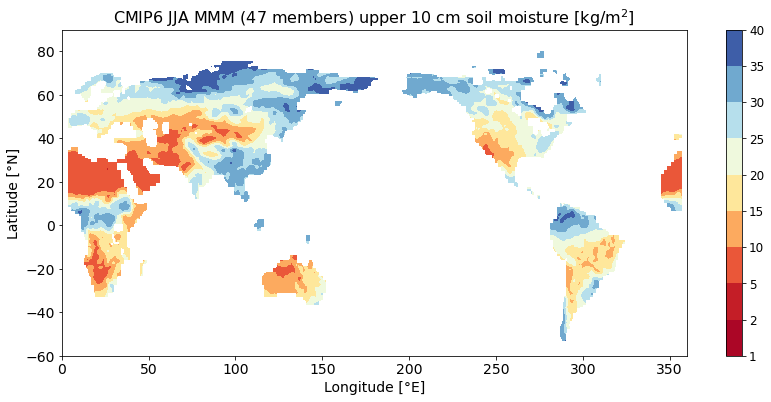

In [19]:
# Read the netcdf file with the seasonal MMM previously computed.

ds = xr.open_dataset(label_season + '_MMM_mrsos_single_member.nc')
counter = ds.mrsos.attrs['counter']
mean_season_mrsos = ds.mrsos.values/counter

lon = ds.longitude.values
lat = ds.latitude.values

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mean_season_mrsos,levels=[1,2,5,10,15,20,25,30,35,40],cmap='RdYlBu')#,shading='nearest')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)# Compute for each model the anomaly with respect to the MMM, for the specified season.
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('CMIP6 ' + label_season + ' MMM ('+str(counter)+' members) upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
plt.savefig('mmm_'+label_season+'_mrsos_1979-2014_single_member.png',bbox_inches='tight')

/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/
r30i1p1f1
----------
/bdd/CMIP6/CMIP/IPSL/IPSL-CM5A2-INCA/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR-INCA/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/historical/
r1i1p1f2
----------
/bdd/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/historical/
r3i1p1f2
----------
/bdd/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/
r3i1p1f2
----------
/bdd/CMIP6/CMIP/BCC/BCC-ESM1/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/
r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


----------
/bdd/CMIP6/CMIP/NCAR/CESM2-WACCM-FV2/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/NCAR/CESM2-FV2/historical/
r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


----------
/bdd/CMIP6/CMIP/NCAR/CESM2/historical/
r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


----------
/bdd/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/CAS/FGOALS-g3/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/SNU/SAM0-UNICON/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/
r3i1p1f2
----------
/bdd/CMIP6/CMIP/AWI/AWI-ESM-1-1-LR/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/
r3i1p1f2


<ipython-input-6-fff22f6e52e3>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(14,6))


----------
/bdd/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/
r7i1p5f1
----------
/bdd/CMIP6/CMIP/CCCma/CanESM5/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/
r1i1p2f1
----------
/bdd/CMIP6/CMIP/E3SM-Project/E3SM-1-1/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/E3SM-Project/E3SM-1-0/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/E3SM-Project/E3SM-1-1-ECA/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/CAMS/CAMS-CSM1-0/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/NIMS-KMA/KACE-1-0-G/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/NIMS-KMA/UKESM1-0-LL/historical/
r14i1p1f2
----------
/bdd/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg-LR/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/CMCC/CMCC-ESM2/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/historical/
r1i1p1f1
-----

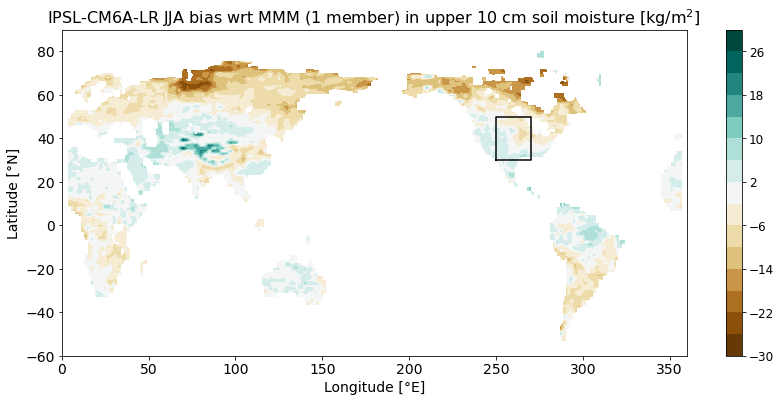

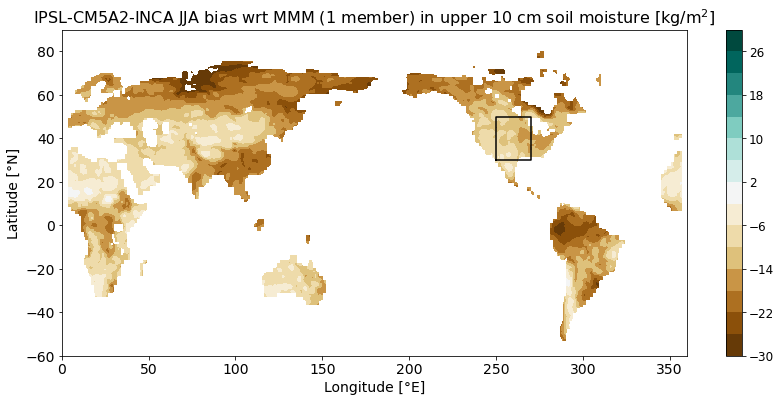

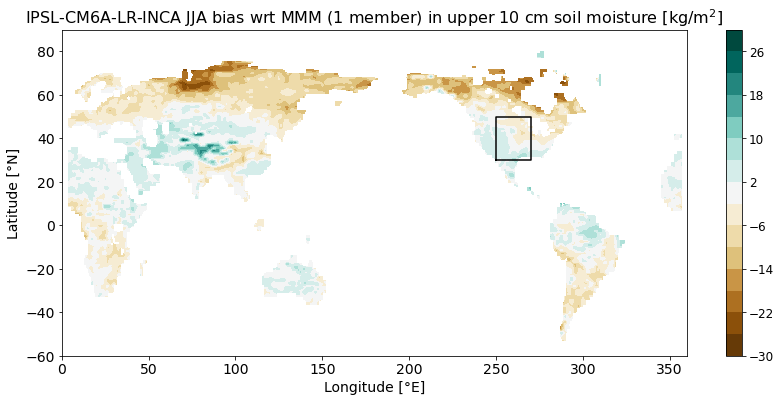

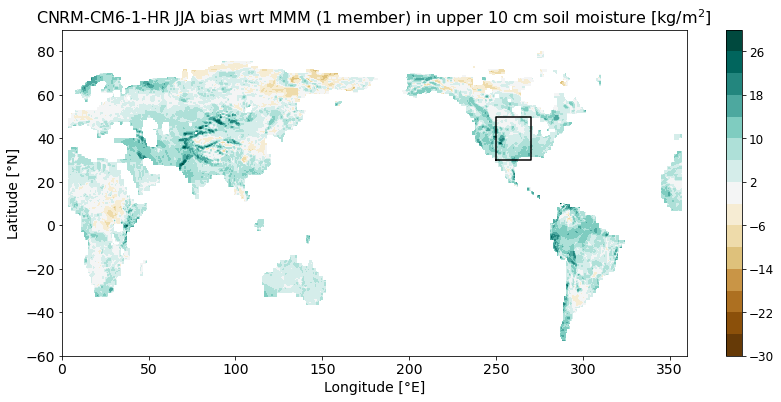

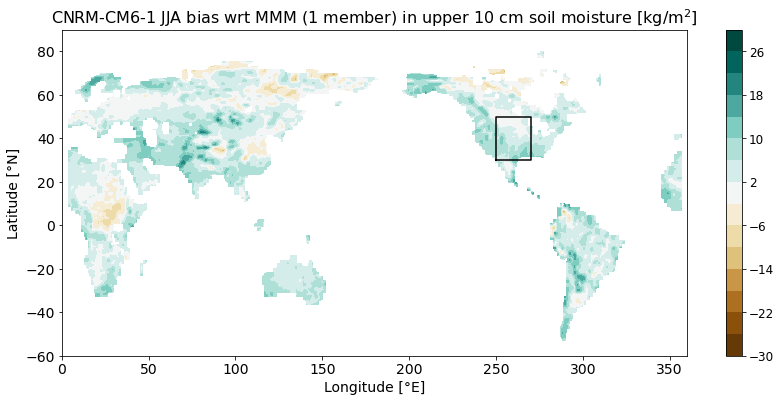

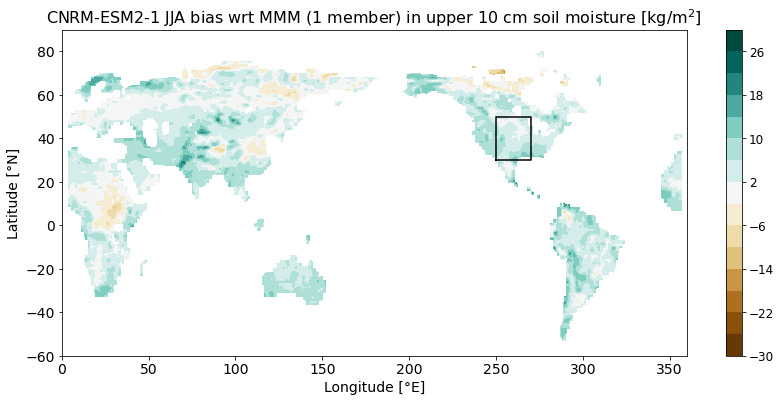

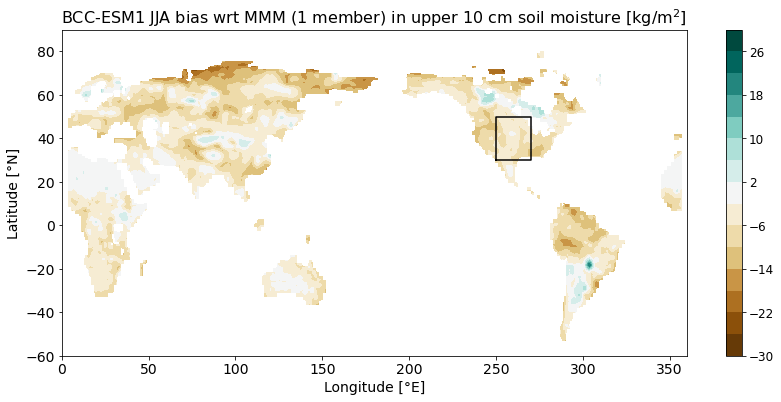

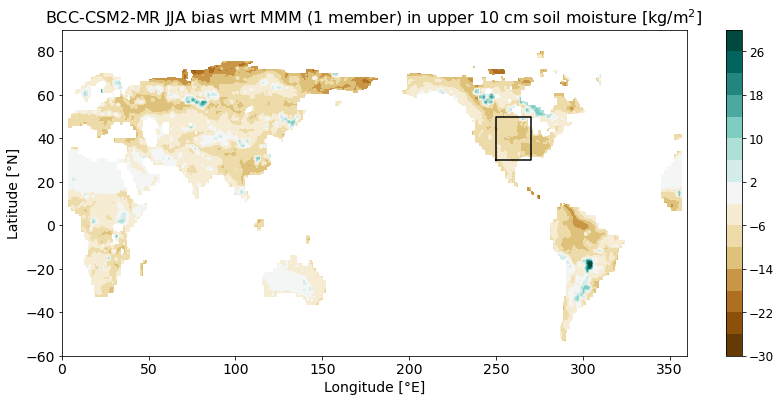

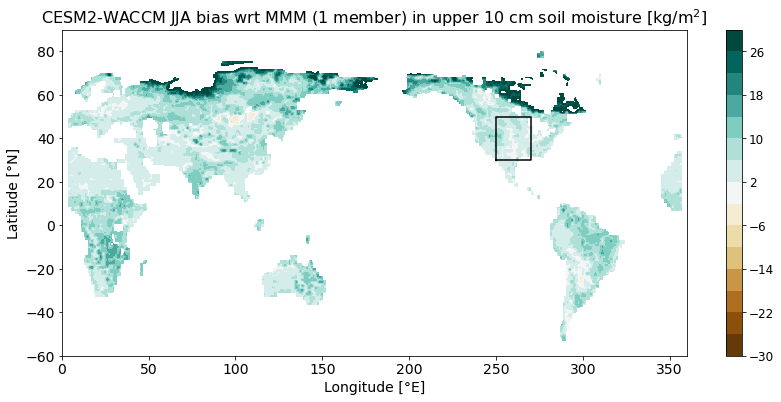

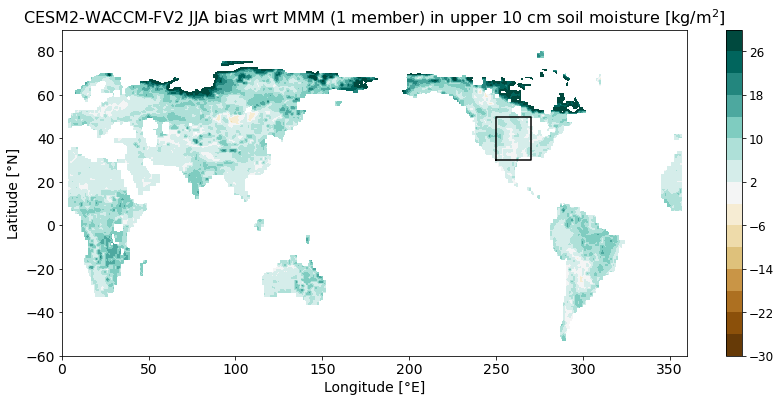

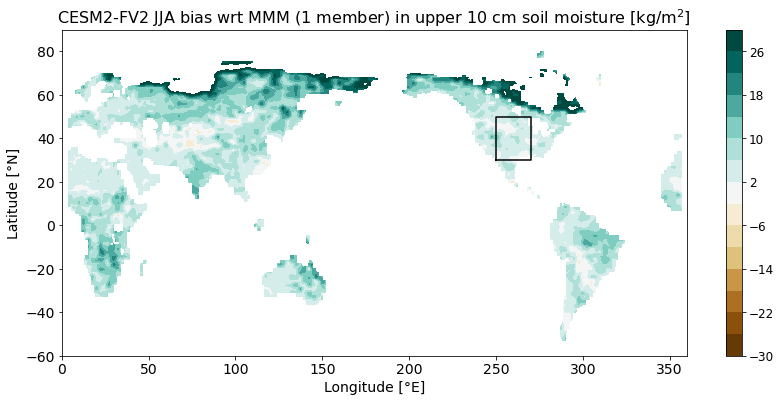

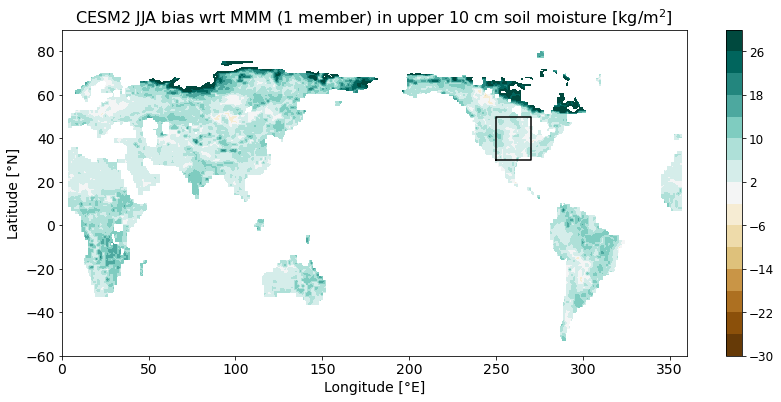

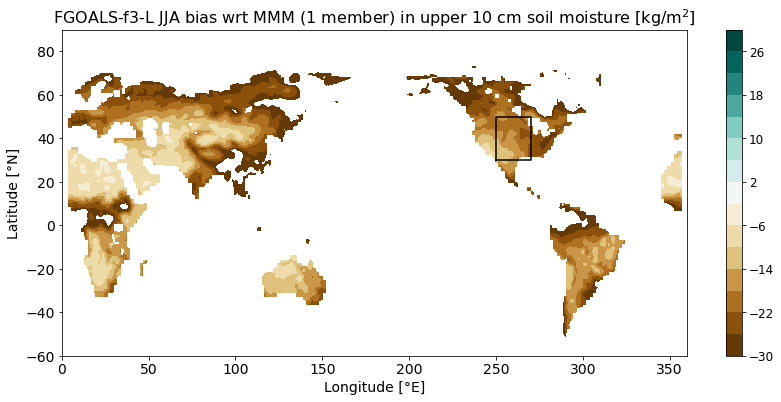

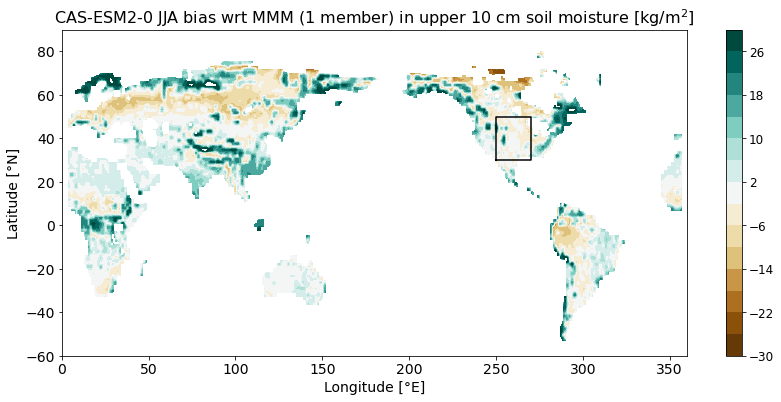

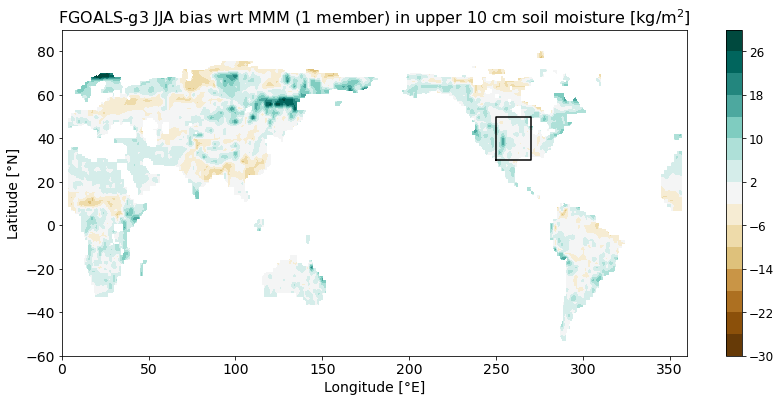

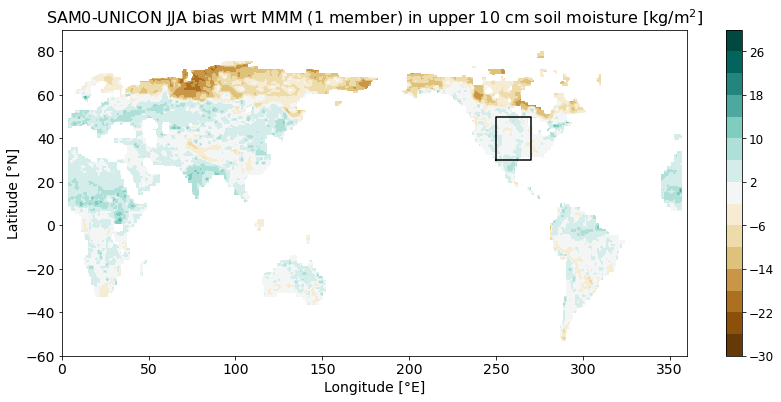

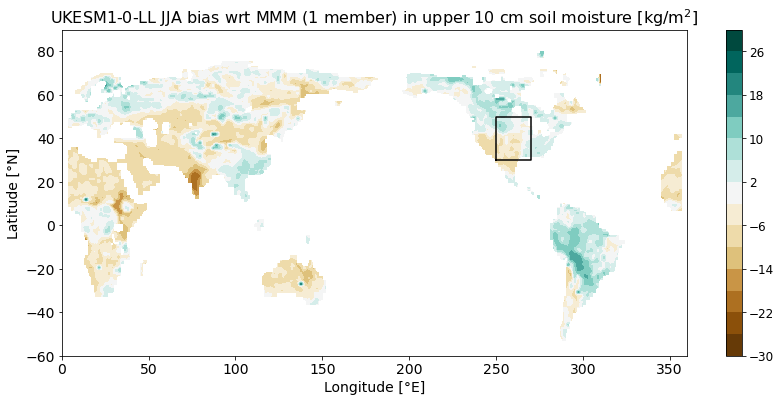

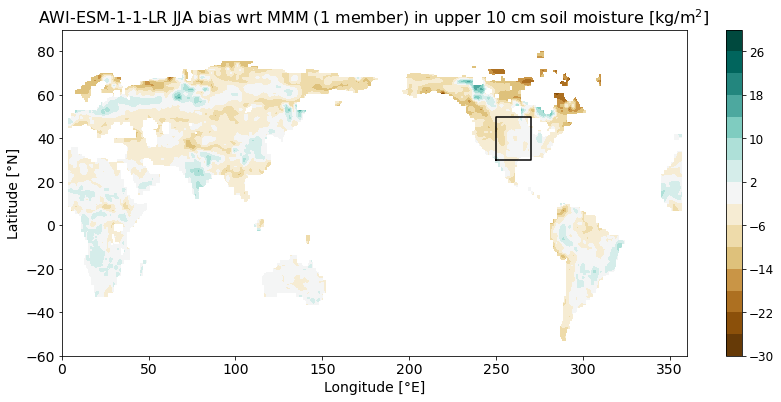

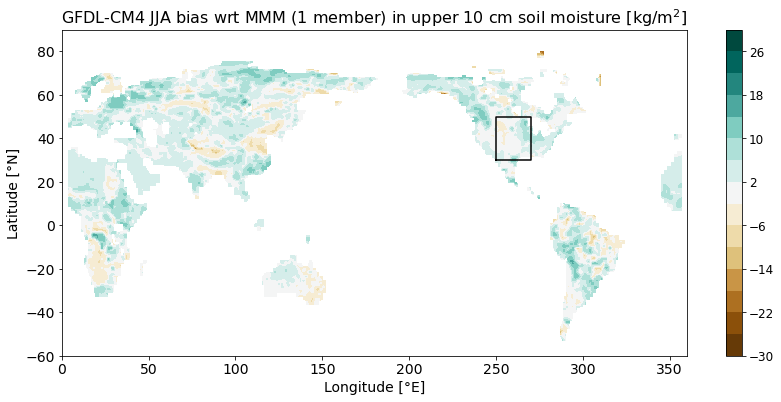

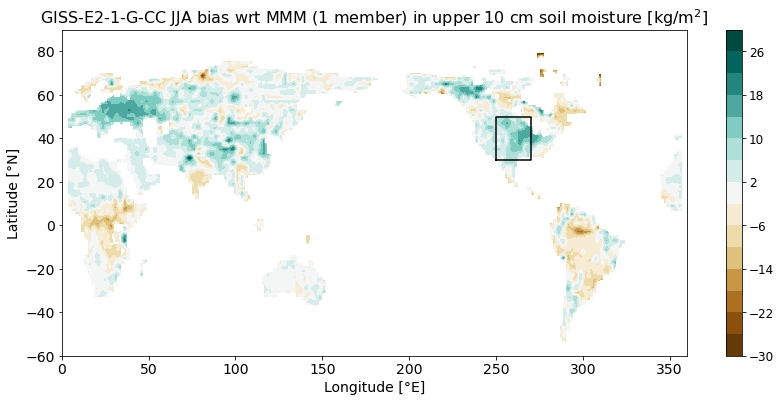

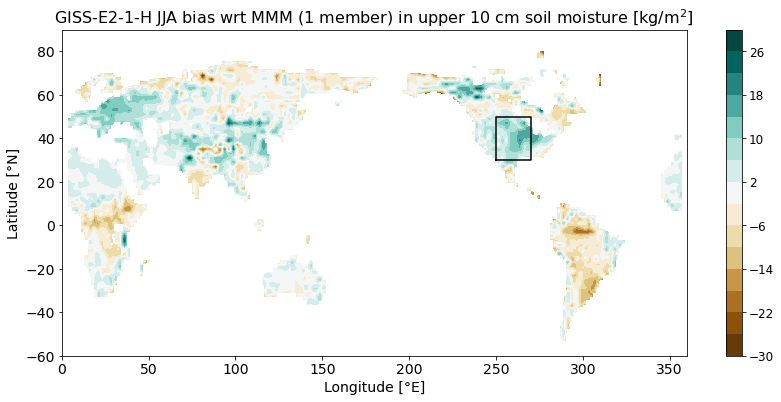

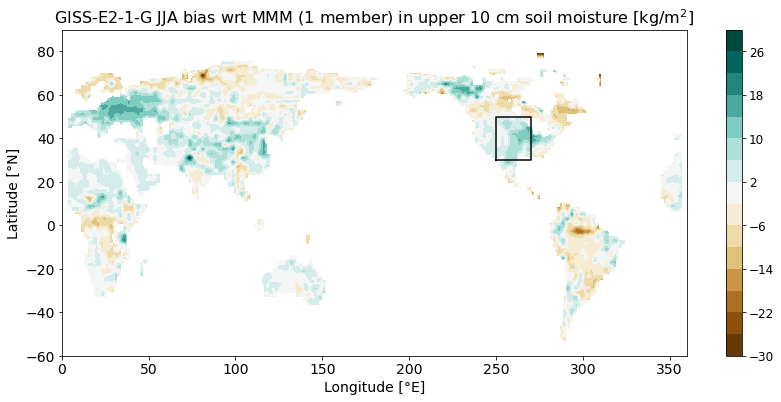

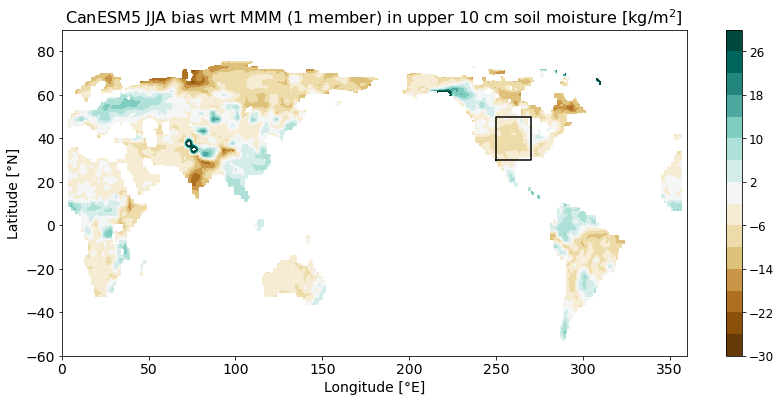

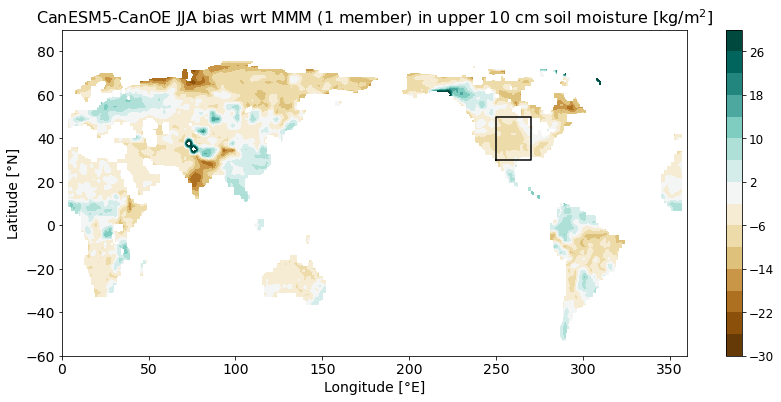

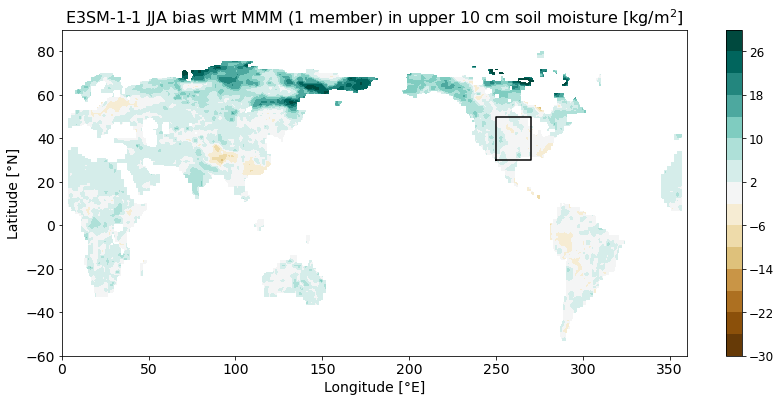

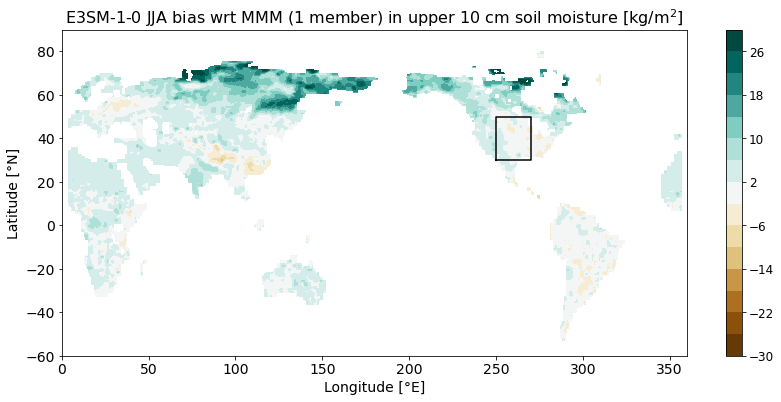

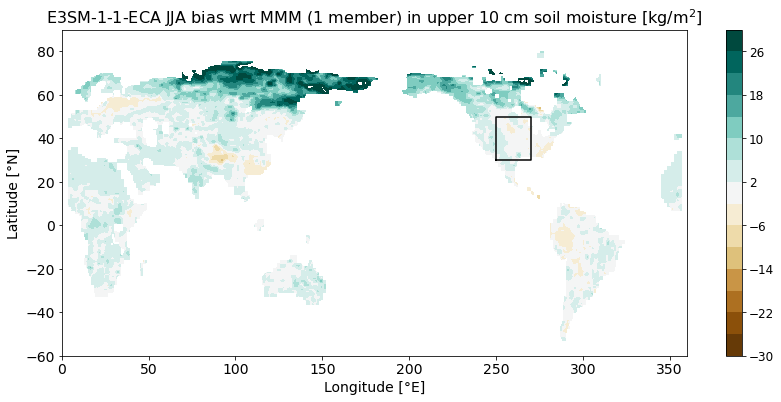

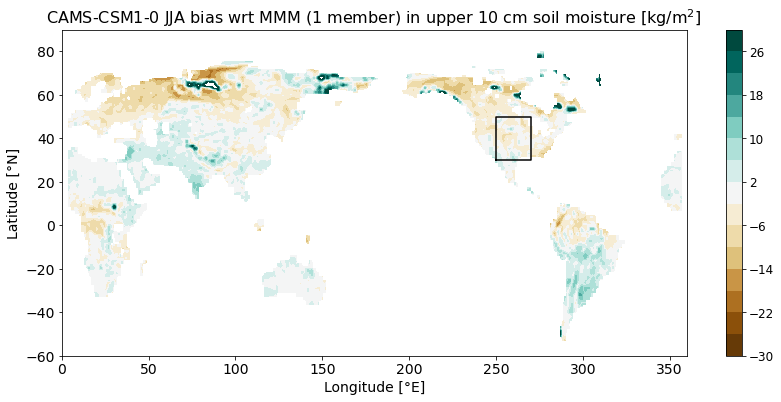

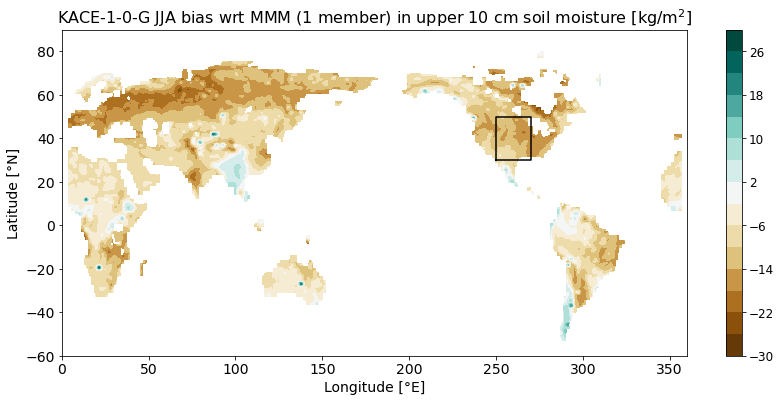

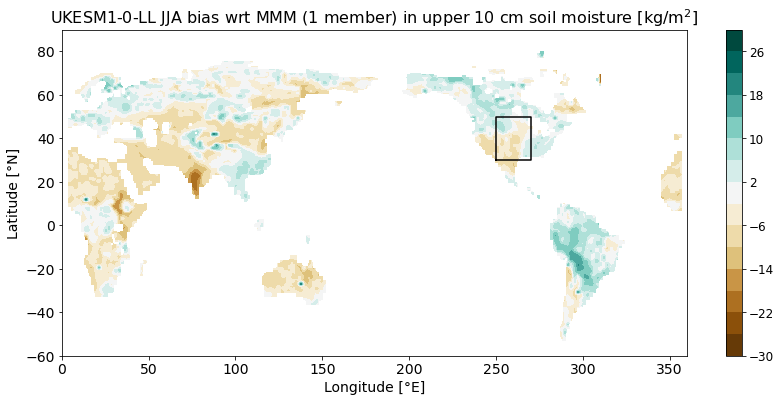

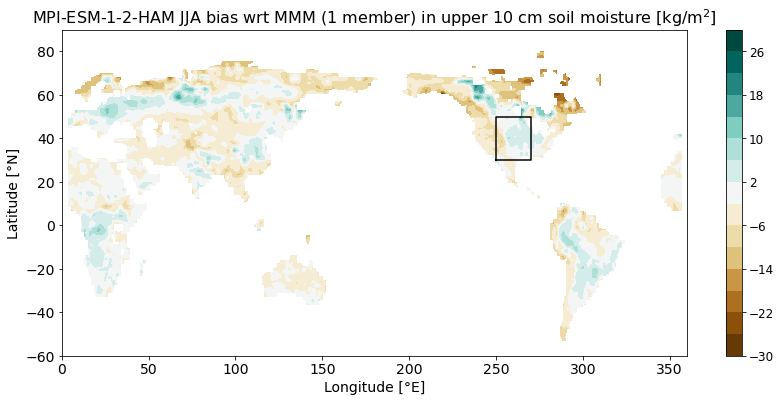

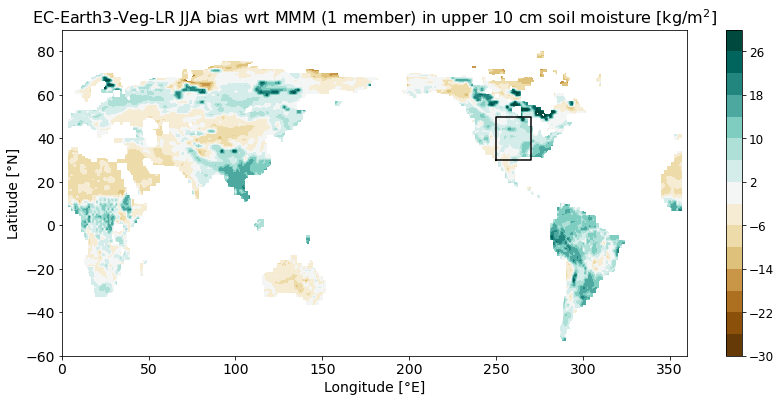

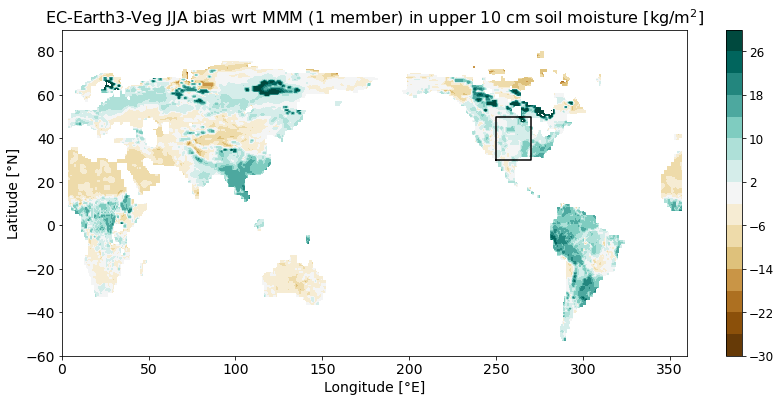

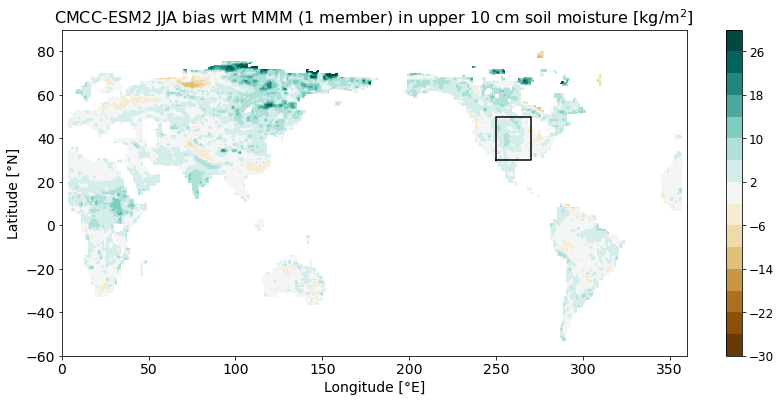

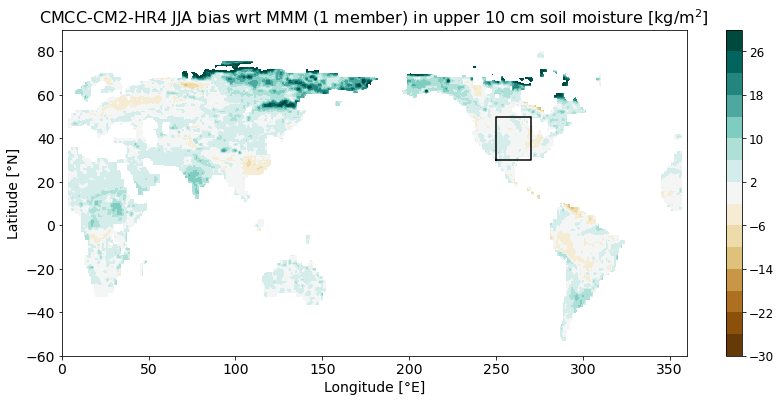

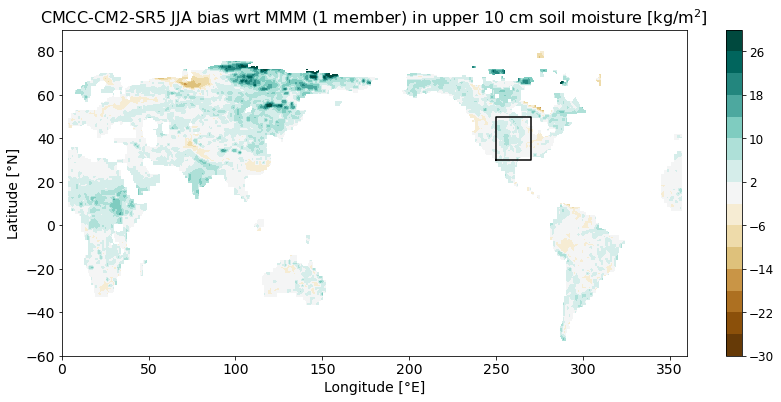

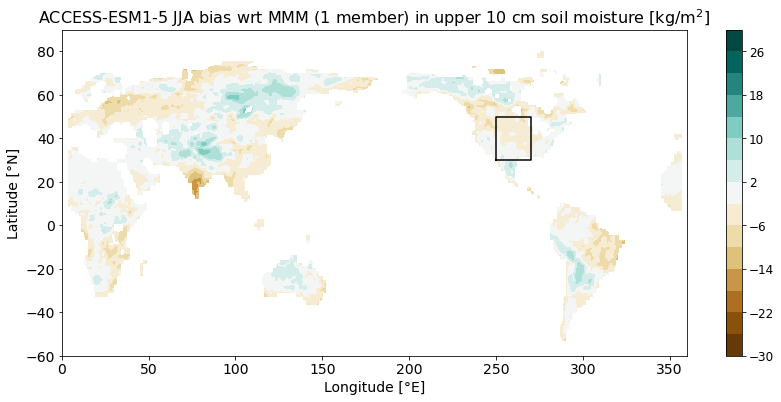

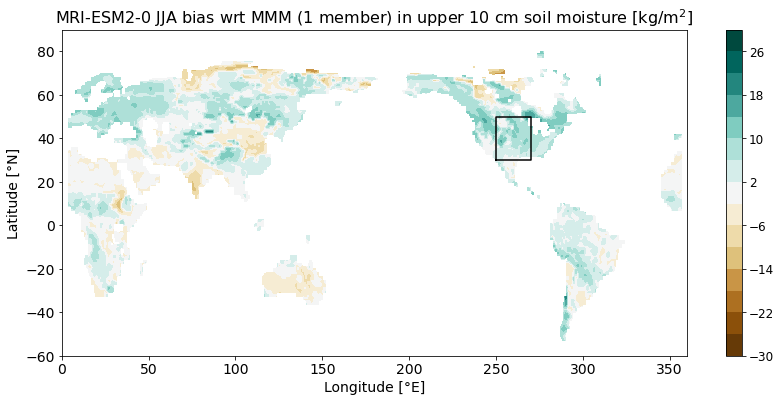

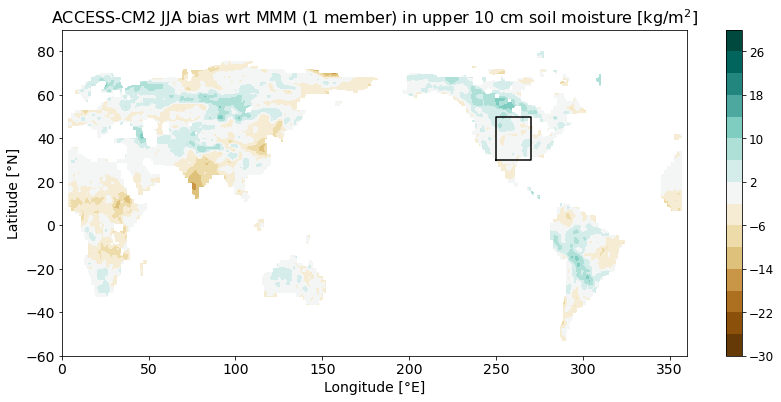

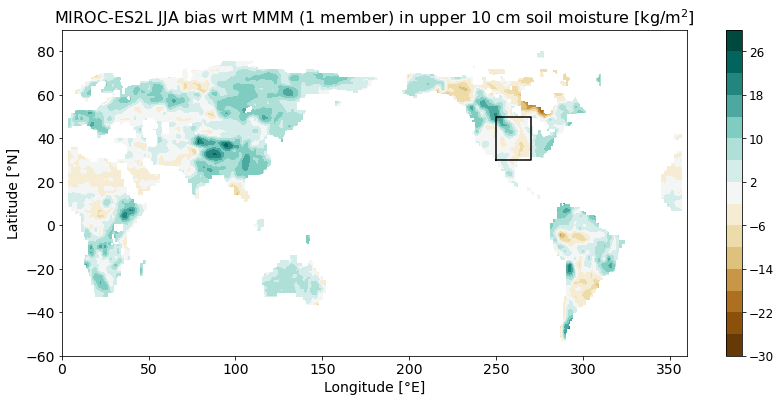

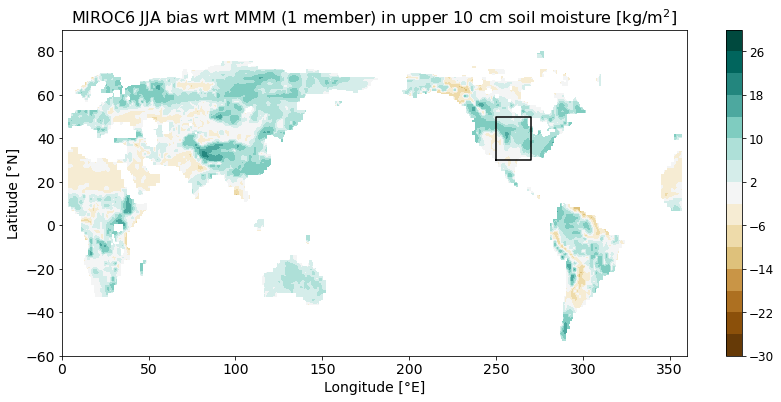

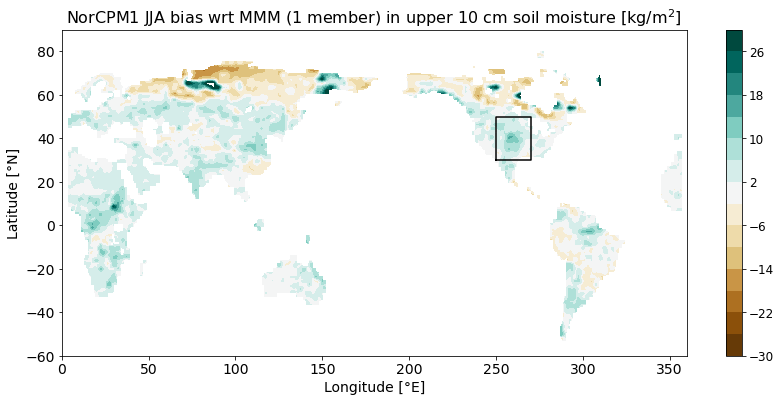

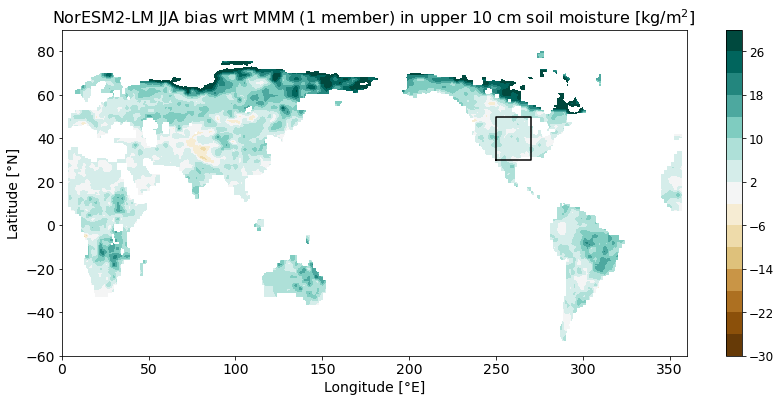

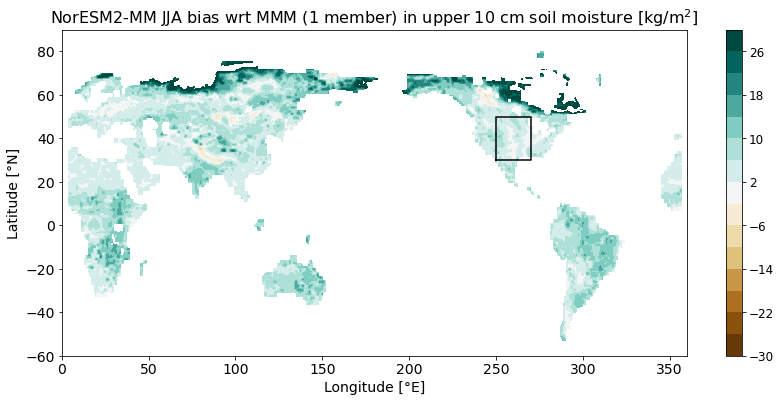

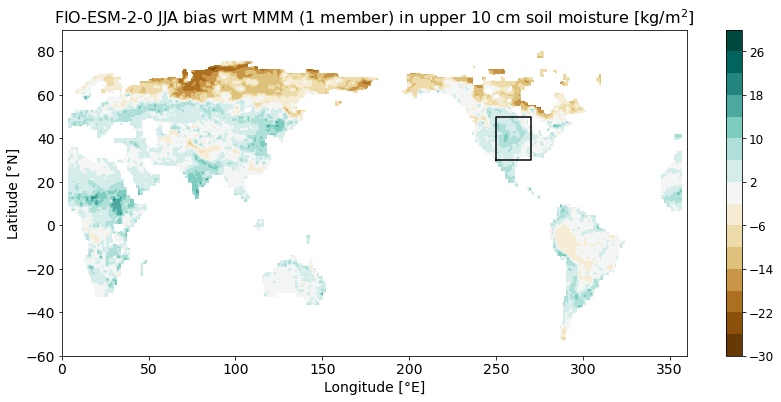

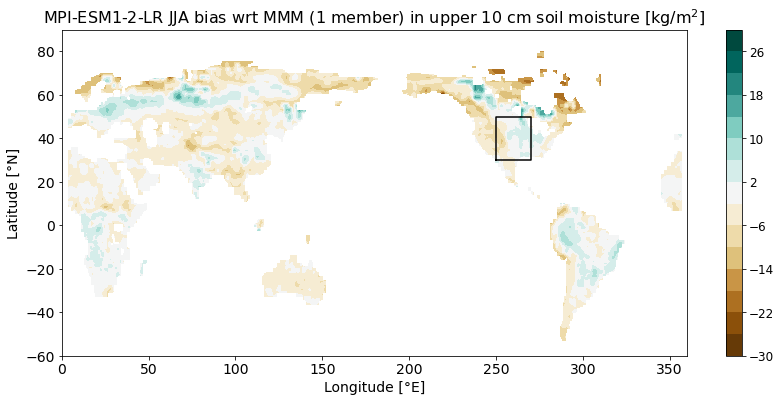

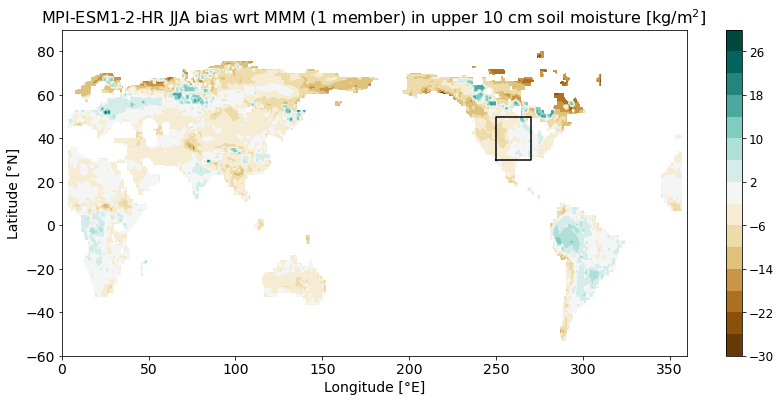

In [6]:
# Compute for each model the anomaly with respect to the MMM, for the specified season.
# Define an area of interest over the north-western CONUS (as in Teng et al., 2019) and stratify the model with respect to the boreal summer MMbias in 
# this region. The area selected is {110-90 W; 30-50N}, as in Fig 1f of Teng et al. 2019.

counter = 0

local_anomaly = np.array([]) # This stores the spatial mean of the MMbias in the area selected by 'extent', for all the models considered.
effective_models = []

# Read the models from the list previously compiled. Here one member for each model is used.
paths_used_with_mrsos = pd.read_csv(label_season+'_paths_used_with_mrsos.csv')
used_path2members = paths_used_with_mrsos.used_path2members
used_members = paths_used_with_mrsos.used_members
used_models = paths_used_with_mrsos.used_models

for kk in range(len(used_members)):
    path2members = used_path2members[kk]
    member = used_members[kk]
    model = used_models[kk]
    if os.path.exists(path2members + member + '/Lmon/mrsos/gr/latest/'):
        path2files = path2members + member + '/Lmon/mrsos/gr/latest/'
    elif os.path.exists(path2members + member + '/Lmon/mrsos/gr1/latest/'):
        path2files = path2members + member + '/Lmon/mrsos/gr1/latest/'
    elif os.path.exists(path2members + member + '/Lmon/mrsos/gn/latest/'):
        path2files = path2members + member + '/Lmon/mrsos/gn/latest/'
    else:
        path2files = ''

    if path2files: # If some data are available the path2file is not empty.
        # Open and concatenate all the files whose final date is after 197901.
        list_of_files = sorted(os.listdir(path2files))
        if list_of_files: # Check whether there are output files to be read.
            print(path2members)
            print(member)
            
            first_file = 1 
            for ll in range(len(list_of_files)):
                filename = list_of_files[ll]
                final_date = filename[-9:-3]
                if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                    da = xr.open_dataset(path2files + filename)
                    if first_file:
                        db = da
                        first_file = 0
                    else:
                        db = xr.concat([db,da],dim='time')

            # Select the time window according to the type of time axis.
            if db.time.dtype=='datetime64[ns]':
                instant_start = np.datetime64('1979-01-01')
                instant_end = np.datetime64('2014-12-31')
            else:
                if db.time.values[0].calendar=='noleap':
                    instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                    instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                elif db.time.values[0].calendar=='360_day':
                    instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                    instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     
    
            # Compute the seasonal MMbias in the time frame of interest and interpolate it on the ERA5 grid.
            d_time = db.mrsos.sel(time=slice(instant_start,instant_end)) # Select the time window.
            d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
            d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
            d_mean4bias = d_season_i-mean_season_mrsos
            counter += 1
                
            # Compute the local anomaly in the area of interest.
            anom = d_mean4bias.sel(longitude=slice(extent[0],extent[1]),latitude=slice(extent[3],extent[2])).mean('longitude',skipna=True).mean('latitude',skipna=True)
            local_anomaly = np.append(local_anomaly,anom)
            effective_models.append(model)
            
            # Plot the map of the bias for a given model.
            mmbias_season_mrsos = d_mean4bias.values

            fig = plt.figure(figsize=(14,6))
            pc = plt.contourf(lon,lat,mmbias_season_mrsos,levels=np.arange(-30,34,4),cmap='BrBG')
            plt.plot([extent[0],extent[1],extent[1],extent[0],extent[0]],[extent[2],extent[2],extent[3],extent[3],extent[2]],'k')
            plt.xlabel('Longitude [°E]',fontsize=14)
            plt.ylabel('Latitude [°N]',fontsize=14)
            plt.ylim([-60,90])
            plt.tick_params(axis='both',labelsize=14)

            cb = plt.colorbar(pc)
            cb.ax.tick_params(labelsize=12)

            plt.title(model+ ' '+ label_season +' bias wrt MMM (1 member) in upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
            plt.savefig('mmbias/mmbias_'+ label_season + '_' + model + '_mrsos_1979-2014_single_member.png',bbox_inches='tight')
                                        
            print('----------')
    
print('Number of members actually used in total: '+ str(counter))

In [13]:
# Save as a txt file the variables local_anomaly, effective_models and effective_members.
dict = {'local_anomaly_kg_m-2': list(local_anomaly), 'effective_models': effective_models}  
df = pd.DataFrame(dict)
     
# saving the dataframe
df.to_csv(label_season+'_local_anomaly_mrsos_single_member.csv')

df

,local_anomaly_kg_m-2,effective_models
0,-0.771665,IPSL-CM6A-LR
1,-11.089547,IPSL-CM5A2-INCA
2,-0.048077,IPSL-CM6A-LR-INCA
3,5.144672,CNRM-CM6-1-HR
4,4.198696,CNRM-CM6-1
5,4.302328,CNRM-ESM2-1
6,-5.887560,BCC-ESM1
7,-8.819006,BCC-CSM2-MR
8,3.574482,CESM2-WACCM
9,3.574482,CESM2-WACCM-FV2


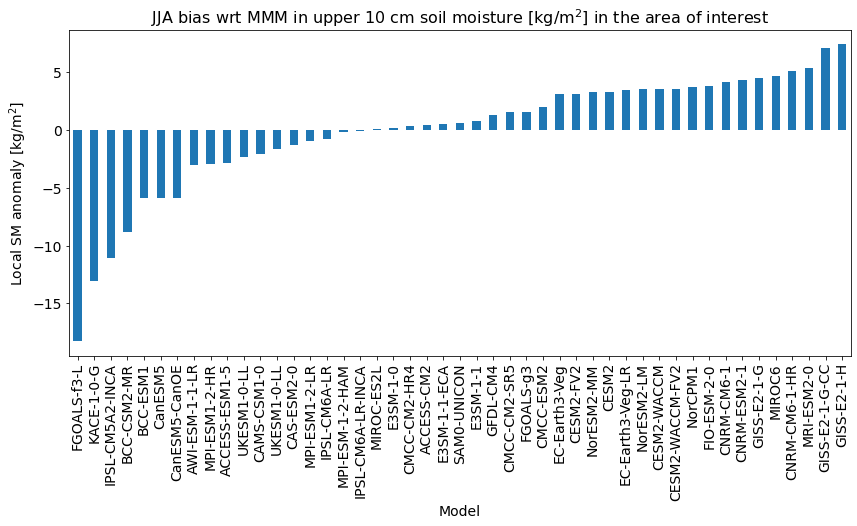

In [18]:
df = pd.read_csv(label_season+'_local_anomaly_mrsos_single_member.csv',index_col=0)

df_sorted = df.sort_values('local_anomaly_kg_m-2')

df_sorted.plot.bar(x='effective_models',y='local_anomaly_kg_m-2',figsize=(14,6),fontsize=14,legend=False)
plt.xlabel('Model',fontsize=14)
plt.ylabel('Local SM anomaly [kg/m$^2$]',fontsize=14)

plt.title(label_season +' bias wrt MMM in upper 10 cm soil moisture [kg/m$^2$] in the area of interest',fontsize=16)
plt.savefig('model_stratification_'+ label_season + '_mrsos_1979-2014_local_anomaly_single_member.png',bbox_inches='tight')

/bdd/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/historical/
r1i1p1f2
----------
/bdd/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/
r3i1p1f2
----------
/bdd/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/
r7i1p5f1
----------
/bdd/CMIP6/CMIP/MRI/MRI-ESM2-0/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/MIROC/MIROC6/historical/
r2i1p1f1
----------
Number of members actually used in total: 6


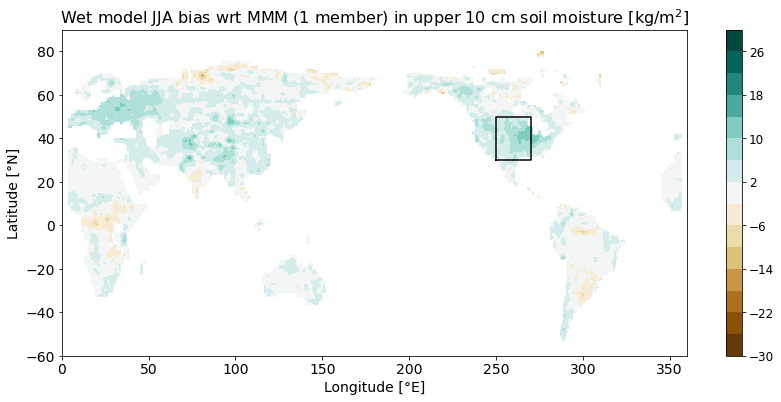

In [9]:
# Now, by looking at the model stratification as a function of the mrsos in North America (as in Teng et al., 2019) select the six 
# models that have the strongest negative anomaly and the six that have the strongest positive anomaly. Compute the anomaly of their 
# mrsos mean with respect to the MMM.

subset = 'dry'
label_subset = 'Dry model'
subset_of_models = ['FGOALS-f3-L','KACE-1-0-G','IPSL-CM5A2-INCA','BCC-CSM2-MR','BCC-ESM1','CanESM5-CanOE'] # Dry models.

subset = 'wet'
label_subset = 'Wet model'
subset_of_models = ['GISS-E2-1-H','GISS-E2-1-G-CC','GISS-E2-1-G','CNRM-CM6-1-HR','MRI-ESM2-0','MIROC6'] # Wet models.

counter = 0
first_field = 1

# Read the models from the list previously compiled. Here one member for each model is used.
paths_used_with_mrsos = pd.read_csv(label_season+'_paths_used_with_mrsos.csv')
used_path2members = paths_used_with_mrsos.used_path2members
used_members = paths_used_with_mrsos.used_members
used_models = paths_used_with_mrsos.used_models

for kk in range(len(used_members)):
    path2members = used_path2members[kk]
    member = used_members[kk]
    model = used_models[kk]
    if model in subset_of_models:
        if os.path.exists(path2members + member + '/Lmon/mrsos/gr/latest/'):
            path2files = path2members + member + '/Lmon/mrsos/gr/latest/'
        elif os.path.exists(path2members + member + '/Lmon/mrsos/gr1/latest/'):
            path2files = path2members + member + '/Lmon/mrsos/gr1/latest/'
        elif os.path.exists(path2members + member + '/Lmon/mrsos/gn/latest/'):
            path2files = path2members + member + '/Lmon/mrsos/gn/latest/'
        else:
            path2files = ''

        if path2files: # If some data are available the path2file is not empty.
            # Open and concatenate all the files whose final date is after 197901.
            list_of_files = sorted(os.listdir(path2files))
            if list_of_files: # Check whether there are output files to be read.
                print(path2members)
                print(member)

                first_file = 1 
                for ll in range(len(list_of_files)):
                    filename = list_of_files[ll]
                    final_date = filename[-9:-3]
                    if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                        da = xr.open_dataset(path2files + filename)
                        if first_file:
                            db = da
                            first_file = 0
                        else:
                            db = xr.concat([db,da],dim='time')

                # Select the time window according to the type of time axis.
                if db.time.dtype=='datetime64[ns]':
                    instant_start = np.datetime64('1979-01-01')
                    instant_end = np.datetime64('2014-12-31')
                else:
                    if db.time.values[0].calendar=='noleap':
                        instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                        instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                    elif db.time.values[0].calendar=='360_day':
                        instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                        instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                # Compute the seasonal MMbias in the time frame of interest and interpolate it on the ERA5 grid.
                d_time = db.mrsos.sel(time=slice(instant_start,instant_end)) # Select the time window.
                d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
                d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
                if first_field:
                    d_mean4bias = d_season_i-mean_season_mrsos
                    first_field = 0
                else:
                    d_mean4bias += d_season_i-mean_season_mrsos
                counter += 1
                                       
            print('----------')
    
print('Number of members actually used in total: '+ str(counter))


# Plot the map of the bias for a given model.
mmbias_season_mrsos = d_mean4bias.values/counter

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mmbias_season_mrsos,levels=np.arange(-30,34,4),cmap='BrBG')
plt.plot([extent[0],extent[1],extent[1],extent[0],extent[0]],[extent[2],extent[2],extent[3],extent[3],extent[2]],'k')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title(label_subset+ ' '+ label_season +' bias wrt MMM (1 member) in upper 10 cm soil moisture [kg/m$^2$]',fontsize=16)
plt.savefig('mmbias/mmbias_'+ label_season + '_' + subset + '_mrsos_1979-2014_single_member.png',bbox_inches='tight')

In [30]:
# Now compute the same MMbias for the same subset of models for tas and z500.
# Define the variable of interest and its units and range of validity.

varname = 'tas' # We can compute its trend and compare it to the MMM with fig1 here https://www.nature.com/articles/s41612-023-00410-6 (Zhang et al., npjCAS, 2023)
varname_path = 'tas'
description = '2m air temperature'
units = 'K'
levels = np.arange(235,325,10)
levels_MMbias = np.arange(-11,13,2)


varname = 'z500'
varname_path = 'zg'
description = '500hPa geopotential height'
units = 'm'
levels = np.arange(5000,6100,100)
levels_MMbias = np.arange(-105,115,10)


/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/
r30i1p1f1
----------
/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR-INCA/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/historical/
r1i1p1f2
----------
/bdd/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/historical/
r3i1p1f2
----------
/bdd/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/
r3i1p1f2
----------
/bdd/CMIP6/CMIP/BCC/BCC-ESM1/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/
r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


----------
/bdd/CMIP6/CMIP/NCAR/CESM2-WACCM-FV2/historical/
r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


----------
/bdd/CMIP6/CMIP/NCAR/CESM2-FV2/historical/
r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


----------
/bdd/CMIP6/CMIP/NCAR/CESM2/historical/
r2i1p1f1


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


----------
/bdd/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/
r2i1p1f1
----------
----------
/bdd/CMIP6/CMIP/CAS/FGOALS-g3/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/SNU/SAM0-UNICON/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/
r3i1p1f2
----------
/bdd/CMIP6/CMIP/AWI/AWI-ESM-1-1-LR/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/historical/
r3i1p1f2
----------
/bdd/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/
r7i1p5f1
----------
/bdd/CMIP6/CMIP/CCCma/CanESM5/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/
r1i1p2f1
----------
/bdd/CMIP6/CMIP/E3SM-Project/E3SM-1-1/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/E3SM-Project/E3SM-1-0/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/E3SM-Project/E3SM-1-1-ECA/historical/
r1i1p1f1
----------
/bdd/CMIP6/CMIP/CAMS/CAMS-CSM1-0

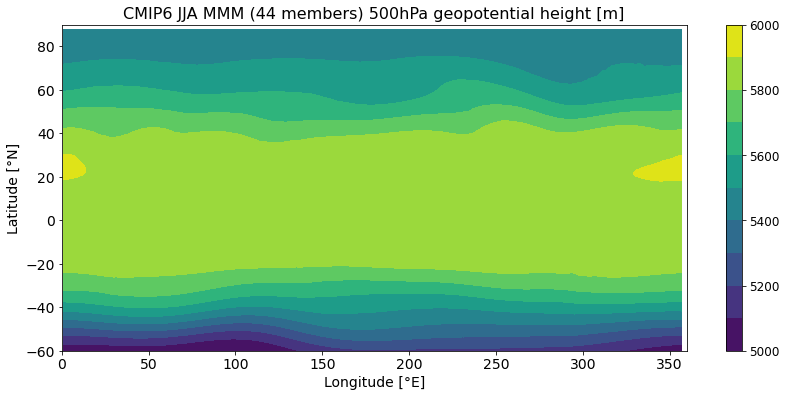

In [31]:
# Compute the seasonal mean considering only the models used for the mrsos MMM.

counter = 0
first_field = 1

# Read the models from the list previously compiled. Here one member for each model is used.
paths_used_with_mrsos = pd.read_csv(label_season+'_paths_used_with_mrsos.csv')
used_path2members = paths_used_with_mrsos.used_path2members
used_members = paths_used_with_mrsos.used_members
used_models = paths_used_with_mrsos.used_models

for kk in range(len(used_members)):
    path2members = used_path2members[kk]
    member = used_members[kk]
    model = used_models[kk]

    if os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr/latest/'):
        path2files = path2members + member + '/Amon/'+varname_path+'/gr/latest/'
    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr1/latest/'):
        path2files = path2members + member + '/Amon/'+varname_path+'/gr1/latest/'
    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gn/latest/'):
        path2files = path2members + member + '/Amon/'+varname_path+'/gn/latest/'
    else:
        path2files = ''

    if path2files: # If some data are available the path2file is not empty.
        # Open and concatenate all the files whose final date is after 197901.
        list_of_files = sorted(os.listdir(path2files))
        if list_of_files: # Check whether there are output files to be read.
            print(path2members)
            print(member)

            first_file = 1 
            for ll in range(len(list_of_files)):
                filename = list_of_files[ll]
                final_date = filename[-9:-3]
                if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                    da = xr.open_dataset(path2files + filename)
                    # Read the variable of interest, so that the reading is faster.
                    if varname=='z500': # Select the variable at the right pressure level.
                        da_var = da['zg'].sel(plev=50000,method='nearest')
                    else:
                        da_var = da[varname]

                    if first_file:
                        db = da_var
                        first_file = 0
                    else:
                        db = xr.concat([db,da_var],dim='time')

            # Select the time window according to the type of time axis.
            if db.time.dtype=='datetime64[ns]':
                instant_start = np.datetime64('1979-01-01')
                instant_end = np.datetime64('2014-12-31')
            else:
                if db.time.values[0].calendar=='noleap':
                    instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                    instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                elif db.time.values[0].calendar=='360_day':
                    instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                    instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

            # Compute the seasonal MMbias in the time frame of interest and interpolate it on the ERA5 grid.
            d_time = db.sel(time=slice(instant_start,instant_end)) # Select the time window.
            d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
            d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.

            if np.sum(np.isnan(d_season_i.values))<450e3: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.
                if first_field:
                    d_mean4MMM_seasonal = d_season_i
                    first_field=0
                else:
                    d_mean4MMM_seasonal += d_season_i
                counter += 1

        print('----------')

print('Number of members actually used in total: '+ str(counter))

# Save the seasonal MMM as netcdf file.
d_mean_season = d_mean4MMM_seasonal.assign_attrs(counter=counter, units=units)
d_mean_season.to_netcdf(label_season + '_MMM_'+varname+'_single_member.nc')

# Read the seasonal mean from the netcdf file.
d_mean_season_nc = xr.open_dataset(label_season + '_MMM_'+varname+'_single_member.nc')
counter = d_mean_season_nc[varname_path].attrs['counter']
mean_seasonal = d_mean_season_nc[varname_path].values/counter

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mean_seasonal,levels=levels)#,cmap='RdYlBu')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('CMIP6 ' + label_season + ' MMM ('+str(counter)+' members) '+description+' ['+units+']',fontsize=16)
plt.savefig('mmm_'+varname+'_'+label_season+'_1979-2014_single_member.png',bbox_inches='tight')

/bdd/CMIP6/CMIP/BCC/BCC-ESM1/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/
r2i1p1f1
----------
/bdd/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/
r1i1p2f1
----------
/bdd/CMIP6/CMIP/NIMS-KMA/KACE-1-0-G/historical/
r2i1p1f1
----------
Number of members actually used in total: 5


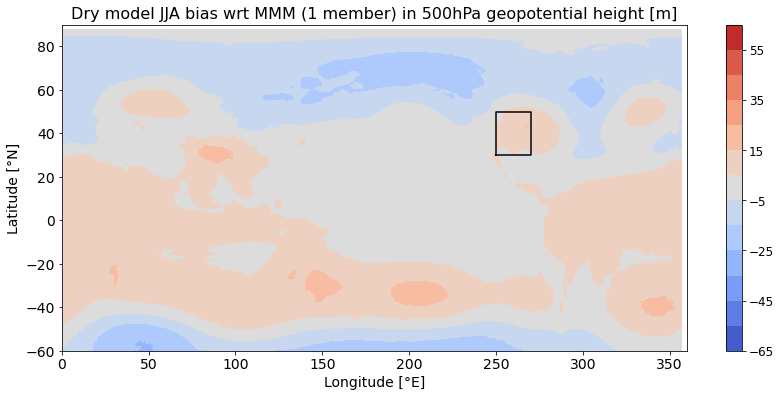

In [41]:
# Now, by looking at the model stratification as a function of the mrsos in North America (as in Teng et al., 2019) select the six 
# models that have the strongest negative anomaly and the six that have the strongest positive anomaly. Compute the anomaly of their 
# mrsos mean with respect to the MMM.

subset = 'dry'
label_subset = 'Dry model'
subset_of_models = ['FGOALS-f3-L','KACE-1-0-G','IPSL-CM5A2-INCA','BCC-CSM2-MR','BCC-ESM1','CanESM5-CanOE'] # Dry models.

#subset = 'wet'
#label_subset = 'Wet model'
#subset_of_models = ['GISS-E2-1-H','GISS-E2-1-G-CC','GISS-E2-1-G','CNRM-CM6-1-HR','MRI-ESM2-0','MIROC6'] # Wet models.

counter = 0
first_field = 1

# Read the models from the list previously compiled. Here one member for each model is used.
paths_used_with_mrsos = pd.read_csv(label_season+'_paths_used_with_mrsos.csv')
used_path2members = paths_used_with_mrsos.used_path2members
used_members = paths_used_with_mrsos.used_members
used_models = paths_used_with_mrsos.used_models

for kk in range(len(used_members)):
    path2members = used_path2members[kk]
    member = used_members[kk]
    model = used_models[kk]
    if model in subset_of_models:
        if os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr/latest/'):
            path2files = path2members + member + '/Amon/'+varname_path+'/gr/latest/'
        elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr1/latest/'):
            path2files = path2members + member + '/Amon/'+varname_path+'/gr1/latest/'
        elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gn/latest/'):
            path2files = path2members + member + '/Amon/'+varname_path+'/gn/latest/'
        else:
            path2files = ''

        if path2files: # If some data are available the path2file is not empty.
            # Open and concatenate all the files whose final date is after 197901.
            list_of_files = sorted(os.listdir(path2files))
            if list_of_files: # Check whether there are output files to be read.
                print(path2members)
                print(member)

                first_file = 1 
                for ll in range(len(list_of_files)):
                    filename = list_of_files[ll]
                    final_date = filename[-9:-3]
                    if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                        da = xr.open_dataset(path2files + filename)
                        # Read the variable of interest, so that the reading is faster.
                        if varname=='z500': # Select the variable at the right pressure level.
                            da_var = da['zg'].sel(plev=50000,method='nearest')
                        else:
                            da_var = da[varname]

                        if first_file:
                            db = da_var
                            first_file = 0
                        else:
                            db = xr.concat([db,da_var],dim='time')

                # Select the time window according to the type of time axis.
                if db.time.dtype=='datetime64[ns]':
                    instant_start = np.datetime64('1979-01-01')
                    instant_end = np.datetime64('2014-12-31')
                else:
                    if db.time.values[0].calendar=='noleap':
                        instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                        instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                    elif db.time.values[0].calendar=='360_day':
                        instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                        instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                # Compute the seasonal MMbias in the time frame of interest and interpolate it on the ERA5 grid.
                d_time = db.sel(time=slice(instant_start,instant_end)) # Select the time window.
                d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
                d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
                            
                if np.sum(np.isnan(d_season_i.values))<450e3: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.
                    if first_field:
                        d_mean4bias = d_season_i-mean_seasonal
                        first_field = 0
                    else:
                        d_mean4bias += d_season_i-mean_seasonal
                    counter += 1

            print('----------')
    
print('Number of members actually used in total: '+ str(counter))

# Plot the map of the bias for a given model.
mmbias_seasonal = d_mean4bias.values/counter

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mmbias_seasonal,levels=np.arange(-65,75,10),cmap='coolwarm') # levels=np.arange(-3.5,4.5,1), # for tas
plt.plot([extent[0],extent[1],extent[1],extent[0],extent[0]],[extent[2],extent[2],extent[3],extent[3],extent[2]],'k')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title(label_subset+ ' '+ label_season +' bias wrt MMM (1 member) in '+description+' ['+units+']',fontsize=16)
plt.savefig('mmbias/mmbias_'+ label_season + '_' + subset + '_'+varname+'_1979-2014_single_member.png',bbox_inches='tight')